# Analyse van de valbeweging

In deze notebook proberen we een wiskundig model op te stellen voor de valbeweging. Hiervoor gebruiken we de data die jij zelf hebt verzameld met behulp van de Dwenguino. Een wiskundig model voor een beweging is nuttig omdat we het kunnen gebruiken om andere valbewegingen te simuleren en zo voorspellingen te doen.

## Imorteren van bibliotheken
We starten met he importeren van de numpy bibliotheek. Deze bibliotheek maakt het gemakkelijk om gegevens te verwerken. Verder importeren we ook de matplitlib bibliotheek om gegevens te plotten.

In [1]:
# Importeer de numpy bibliotheek als np
import numpy as np
import matplotlib.pyplot as plt

## Inlezen van de gegevens

Voor we kunnen starten met de analyse, moeten we de gegevens uit ons .csv bestand inladen in Python. Daarvoor gebruiken we de *lees_csv_bestand* functie. 

In [2]:
def lees_csv_bestand(file_name):
    data = np.genfromtxt(file_name, skip_header=True, delimiter=';')
    return data

We roepen onze functie op met de padnaam van het bestand dat we willen inladen.

In [3]:
gegevens_valbeweging = lees_csv_bestand('data/valbeweging1.csv')

De functie *lees_csv_bestand* zal de gegevens opslaan in een matrix. Elke rij van de matrix komt overeen met één meting. De eerste kolom bevat de tijden waarop de meting uitgevoerd is (in ms). De tweede kolom bevat de afstandsmeting zelf (in ms). Onderstaande code drukt de eerste vijf rijen van de matrix af.

In [4]:
print(gegevens_valbeweging[0:5])

[[199361.    351.]
 [199375.    347.]
 [199391.    371.]
 [199405.    371.]
 [199420.    371.]]


## De gegevens proper maken

In de uitvoer van de cel hierboven zie je dat zowel de tijd als de afstand vreemde waarden hebben. Bijgevolg gaan we de gegevens eerst wat opkuisen voor we die verder verwerken.

### Tijdstippen

 De tijd wordt weergegeven in miliseconden (= 1/1000 van een seconde) en de eerste meting start niet op tijdstip 0. We willen graag dat de tijd weergegeven wordt in seconden en dat de eerste meting start op tijdstip 0. Dat kunnen we doen met onderstaande code.

In [5]:
# De eerste kolom bevat de tijdstippen in milliseconden, sla deze apart op in een variabele tijdstippen
tijdstippen = gegevens_valbeweging[:, 0]

# Trek van elk tijdstip het eerste tijdstip af. Zo starten de tijdstippen bij 0.
tijdstippen = tijdstippen - tijdstippen[0]

# Deel de tijdstippen door 1000 om ze om te zetten naar seconden.
tijdstippen = tijdstippen/1000 

We kunnen de aangepaste tijdstippen nu ook eens bekijken.

In [6]:
print(tijdstippen[0:5])

[0.    0.014 0.03  0.044 0.059]


### Afstanden

De afstanden worden in ons .csv bestand voorgesteld door tijden (in µs = 1/1000000 seconden). Deze waarden zijn de tijd die het geluid nodig had om vanop de sensor te vertrekken, tegen het object te botsen en terug te keren naar de sensor. Om deze tijden om te kunnen zetten naar afstanden moeten we dus weten wat de snelheid van het geluid is. De snelheid van het geluid in lucht is ongeveer 1cm/28.5µs. Als we een afstand van 1cm meten dan moet het geluit heen en terug gaan dus de tijd die verlopen zal zijn om 1cm te meten is 57µs. We gebruiken deze waarde om onze metingen om te zetten naar centimeter.

In [7]:
# Zet de metingen om naar cm
US_PER_CM_HEEN_EN_TERUG = 57.0
gegevens_valbeweging[:, 1] = gegevens_valbeweging[:, 1] / US_PER_CM_HEEN_EN_TERUG

Omdat de sensor de afstand tot het vallende object van bovenaf meet en niet de hoogte van het object, moeten we de metingen omdraaien. Daarvoor vervangen we elke waarde door het verschil tussen de laatst gemeten waarde (de afstand tot de grond) en de gemeten waarde op dat moment. Zo krijgen we de hoogte van het object op elk tijdstip.

Eens we de afstand hebben in cm, kunnen we die ook eenvoudig omzetten naar meter.

In [8]:
# Neem het verschil van de laaste meting en alle metingen. 
gegevens_valbeweging[:, 1] = gegevens_valbeweging[-1, 1] - gegevens_valbeweging[:, 1]
# Sla de afstanden op in een aparte variabele afstanden en zet deze om naar meter.
afstanden = gegevens_valbeweging[:, 1].reshape(-1, 1)
afstanden = afstanden / 100 

In [9]:
print(afstanden[0:5])

[[0.76912281]
 [0.76982456]
 [0.76561404]
 [0.76561404]
 [0.76561404]]


## De beweging visualiseren

Nu we onze data proper gemaakt hebben, kunnen we die visualiseren. Onderstaande functie krijgt de gegevens, de tijdstippen en een titel mee als parameters en toont deze in een grafiek.

In [10]:
def plot_gegevens(gegevens, tijdstippen, titel='', xlabel="Tijd (s)", ylabel="Hoogte (m)"):
    plt.xticks(np.arange(0, len(gegevens), 10, dtype=np.uint32), tijdstippen[::10].round(2))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(gegevens[:, 0], label='y')
    plt.title(titel)
    # set plot size
    plt.rcParams["figure.figsize"] = (20,10)
    plt.legend()
    plt.show()

We kunnen onze functie nu gebruiken om onze gegevens te visualiseren.

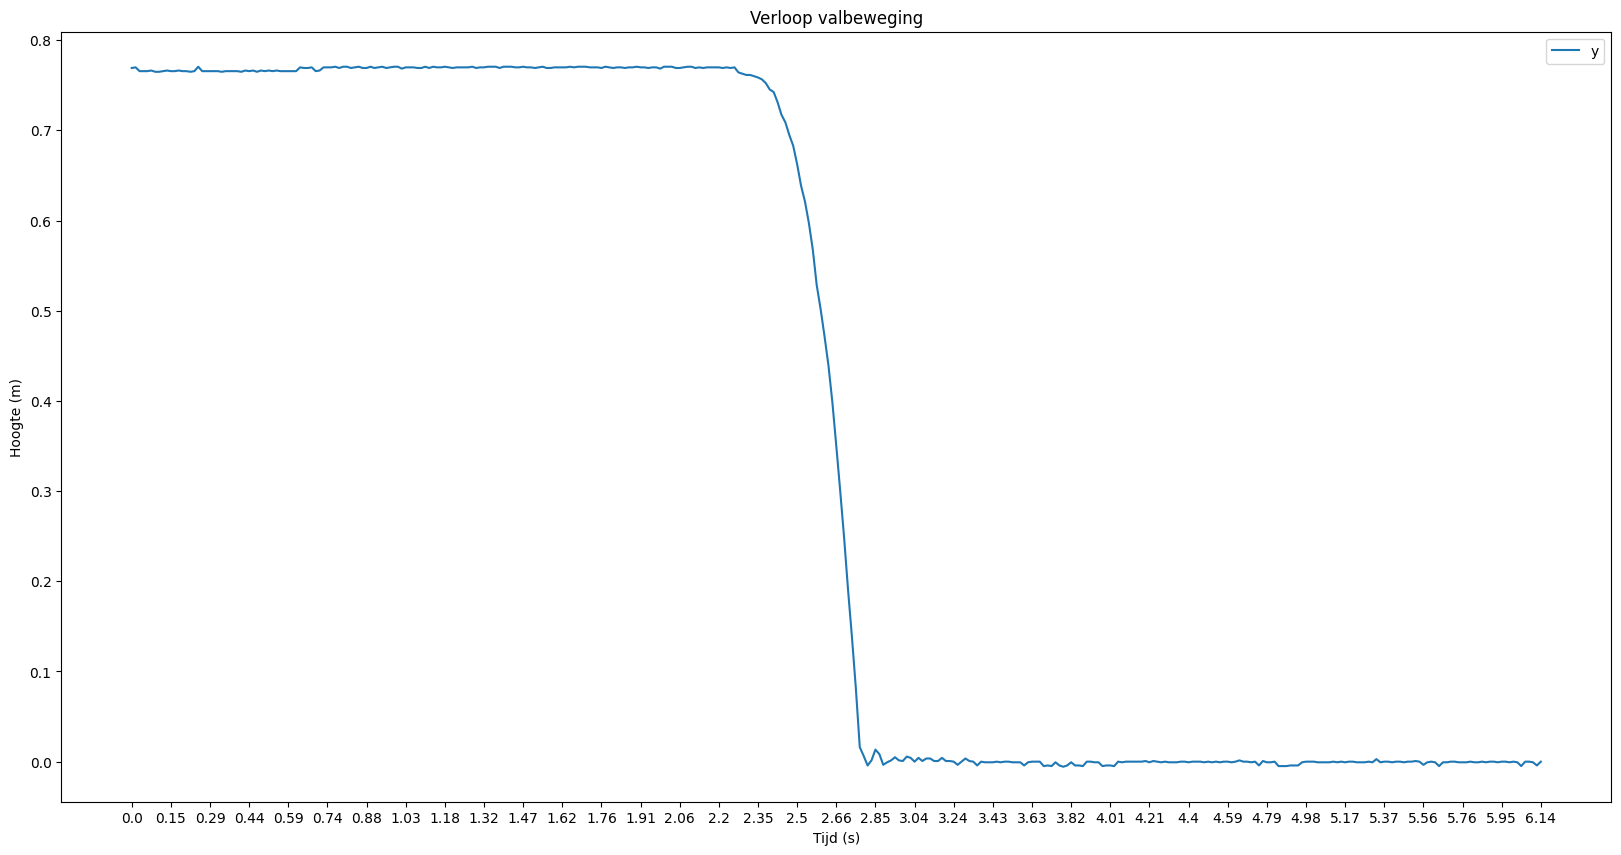

In [12]:
plot_gegevens(afstanden, tijdstippen, titel='Verloop valbeweging', xlabel='Tijd (s)', ylabel='Hoogte (m)')

We zien dat de valbeweging zelf plaatsvindt tussen twee en 3 seconden. We kunnen de beweging dus beter analyseren wanneer we inzoomen op dat tijdsinterval.

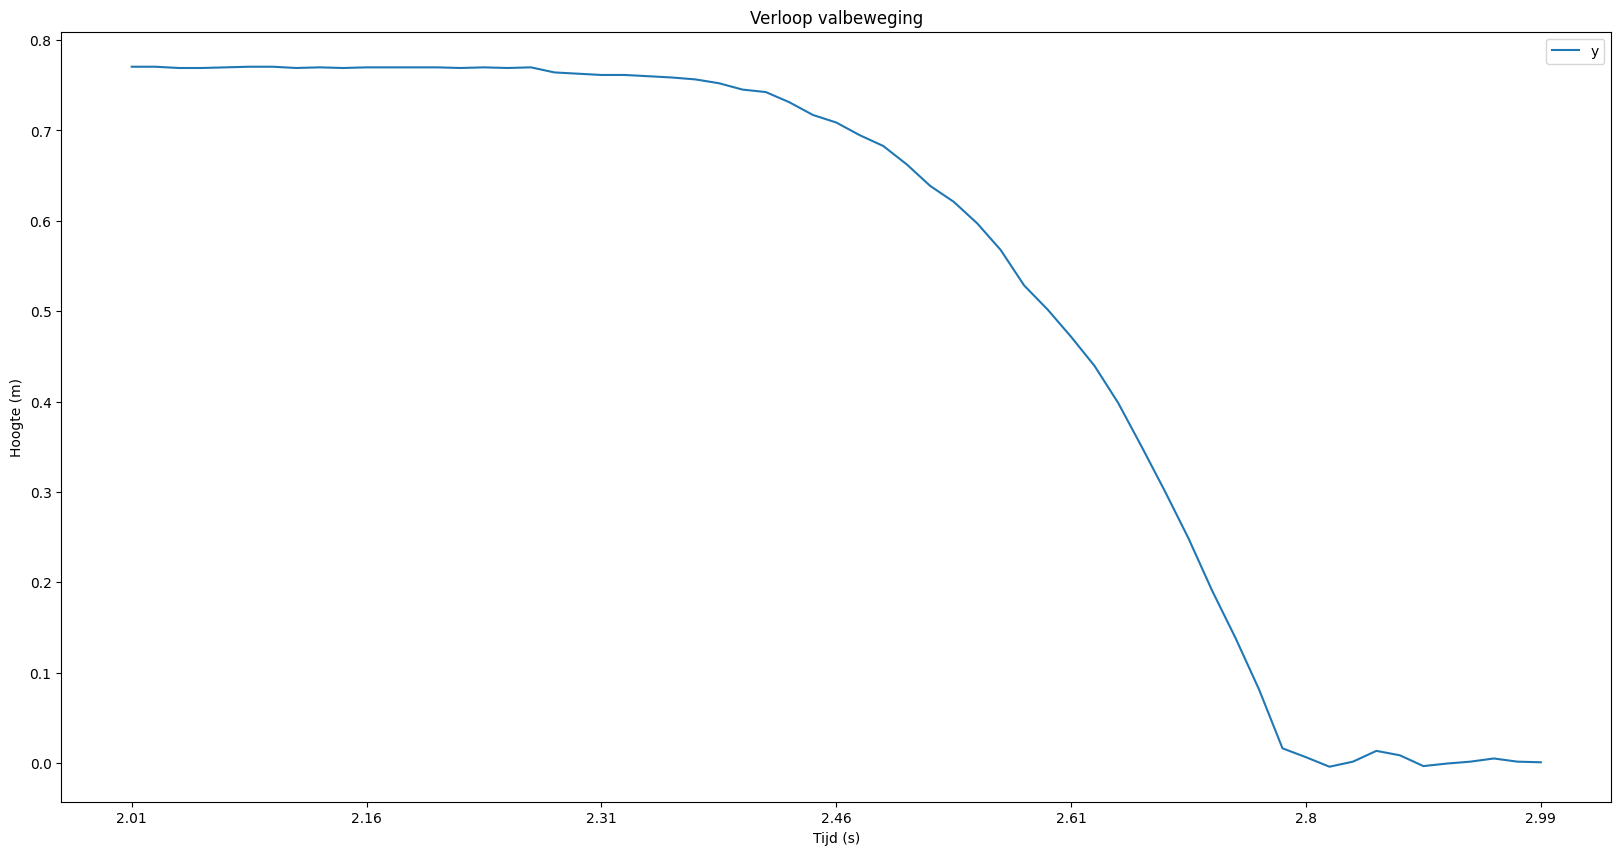

In [13]:
# Zoom in op de data tussen 2 en 3 seconden
start = 2
einde = 3
indices = np.where((tijdstippen > start) & (tijdstippen < einde))
plot_gegevens(afstanden[indices], tijdstippen[indices], titel='Verloop valbeweging', xlabel='Tijd (s)', ylabel='Hoogte (m)')

**Opdracht:** Herken je de curve? Volgens welk voorschrift zou de positie van het voorwerp veranderen?

## Een wiskundig model fitten

Door onze kennis over computerwetenschappen, fysica en wiskunde te combineren kunnen we een model maken van de beweging. Hiervoor baseren we ons op de data van onze sonar-sensor. 
Omdat we enkel een model willen van de valbeweging en niet van de momenten dat je het voorwerp vast had of wanneer het op de grond lag, zoomen we nog wat meer in op onze data.

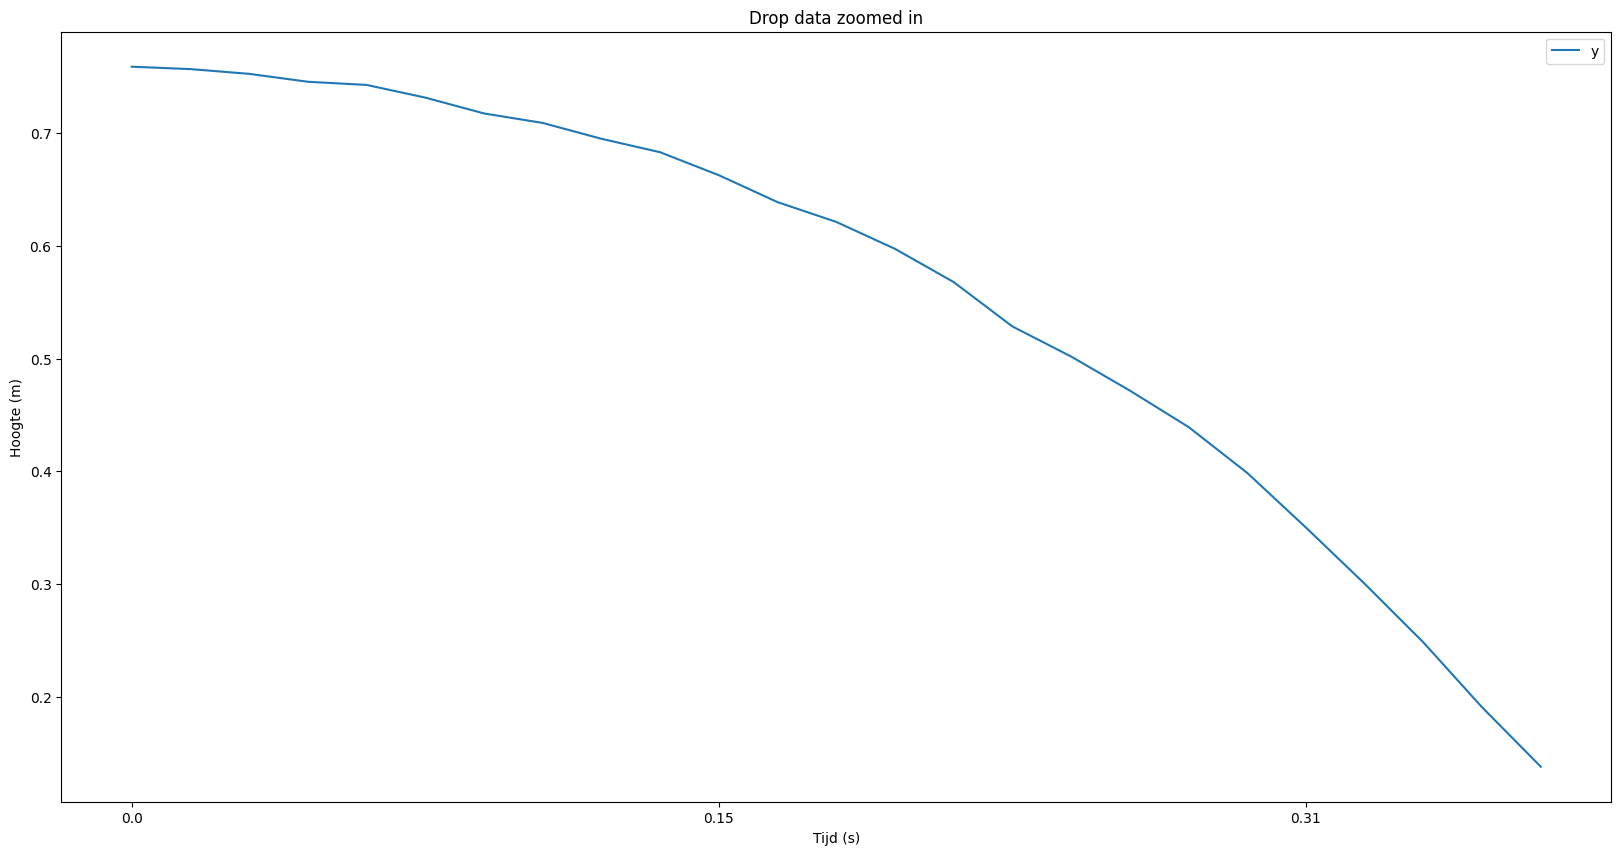

In [15]:
# We zoomen nu in op de data tussen 2.35 en 2.75 seconden
# Leg het startpunt en eindpunt vast
start = 2.350
einde = 2.750

# Zoek de indices van de tijdstippen die tussen start en einde liggen
indices = np.where((tijdstippen > start) & (tijdstippen < einde))

# Selecteer de afstanden en tijden die tussen start en einde liggen
tijden = tijdstippen[indices]
afstanden = afstanden[indices]

# Zorg dat de tijden starten bij 0
tijden = tijden - tijden[0]

# Toon de grafiek
plot_gegevens(afstanden, tijden, 'Drop data zoomed in')

### De kleinste kwadraten methode

Om een model te fitten op onze gegevens maken we gebruik van de methode van de kleinste kwadraten. Deze zal op zoek gaan naar een functie die zo dicht mogelijk bij onze gegevens ligt. 
Voor we de methode kunnen toepassen, moeten we eerst een idee hebben van het soort functie die we gaan fitten op onze gegevens. Wanneer je de grafiek van de valbeweging bekijkt, zou je moeten zien dat deze lijkt op een parabool. Uit de wiskunde weten we dat de grafiek van de parabool volgens het volgende voorschrift verloopt:

\begin{equation}
y = ax^2 + bx + c
\end{equation}

We kennen heel wat waarden voor $x$ en $y$. Dit zijn de metingen die we gedaan hebben met onze sensor. De waarden van $a$, $b$ en $c$ kennen we echter niet. We kunnen de methode van de kleinste kwadraten gebruiken om deze te bepalen. De methode van de kleinste kwadraten zal een stelsel van vergelijkingen oplossen om zo de waarden van $a$, $b$ en $c$ te bepalen. Dit stelsel ziet er als volgt uit:

\begin{equation}
\begin{cases}
y_1 = a x_1^2 + b x_1 + c \\
y_2 = a x_2^2 + b x_2 + c \\
\vdots \\
y_n = a x_n^2 + b x_n + c \\
\end{cases}
\end{equation}

Waarbij de koppels $(x_n, y_n)$ het tijdstip en de hoogte van de n de meting voorstellen (tijdstip_n, hoogte_n). Merk op dat dit stelsel meer vergelijkingen heeft dan onbekenden. We zoeken dus niet zomaar een oplossing maar we zoeken een oplossing waarvoor de som van de kwadraten van de fouten zo klein mogelijk is. Concreet zullen we een $a$, $b$ en $c$ kiezen waarvoor

\begin{equation}
\epsilon = \sum_{1}^{n}{(hoogte_n - y_n)^2}
\end{equation}

minimaal is.

We kunnen het stelsel van vergelijkingen voorstellen als matrices:

\begin{equation}
y = \begin{pmatrix}
  y_1 \\
  y_2 \\
  \vdots \\
  y_n
\end{pmatrix},

X = \begin{pmatrix}
  x_1^2 & x_1 & 1 \\
  x_2^2 & x_2 & 1 \\
  \vdots & \vdots & \vdots \\
  x_n^2 & x_n & 1
\end{pmatrix},
 
\beta = \begin{pmatrix}
  a \\
  b \\
  c
\end{pmatrix}

\end{equation}

\begin{equation}
y = X \beta
\end{equation}

Wiskundigen hebben aangetoond dat je de optimale waarde voor $\beta$ kan vinden aan de hand van de volgende berekening:

\begin{equation}
\beta = (X^T X)^{-1} X^T y
\end{equation}

Om de berekining uit te kunnen voeren moeten we dus de matrix $X$ en de vector $y$ opstellen. De berekening kunnen we Python laten uitvoeren

We beginnen met de tijden en de afstanden voor te stellen als vectoren.

In [16]:
x = tijden
y = afstanden.T[0]

print(x)
print(y)

[0.    0.014 0.03  0.044 0.06  0.074 0.089 0.104 0.119 0.134 0.15  0.165
 0.181 0.197 0.213 0.23  0.246 0.262 0.28  0.296 0.313 0.332 0.349 0.368
 0.386]
[0.75859649 0.75649123 0.7522807  0.74526316 0.74245614 0.73122807
 0.71719298 0.70877193 0.69473684 0.68280702 0.66245614 0.63859649
 0.62105263 0.59719298 0.5677193  0.52842105 0.50175439 0.47157895
 0.43929825 0.39859649 0.35017544 0.30035088 0.24842105 0.19087719
 0.13824561]


Nu kunnen we de matrix $X$ opstellen door als eerste kolom het kwadraat van de vector $x$ te nemen, als tweede kolom de vector $x$ zelf en als laatste kolom een vector met enkel het getal 1.

In [17]:
X = np.vstack((x**2, x, np.ones_like(x))).T
print(X)

[[0.00000e+00 0.00000e+00 1.00000e+00]
 [1.96000e-04 1.40000e-02 1.00000e+00]
 [9.00000e-04 3.00000e-02 1.00000e+00]
 [1.93600e-03 4.40000e-02 1.00000e+00]
 [3.60000e-03 6.00000e-02 1.00000e+00]
 [5.47600e-03 7.40000e-02 1.00000e+00]
 [7.92100e-03 8.90000e-02 1.00000e+00]
 [1.08160e-02 1.04000e-01 1.00000e+00]
 [1.41610e-02 1.19000e-01 1.00000e+00]
 [1.79560e-02 1.34000e-01 1.00000e+00]
 [2.25000e-02 1.50000e-01 1.00000e+00]
 [2.72250e-02 1.65000e-01 1.00000e+00]
 [3.27610e-02 1.81000e-01 1.00000e+00]
 [3.88090e-02 1.97000e-01 1.00000e+00]
 [4.53690e-02 2.13000e-01 1.00000e+00]
 [5.29000e-02 2.30000e-01 1.00000e+00]
 [6.05160e-02 2.46000e-01 1.00000e+00]
 [6.86440e-02 2.62000e-01 1.00000e+00]
 [7.84000e-02 2.80000e-01 1.00000e+00]
 [8.76160e-02 2.96000e-01 1.00000e+00]
 [9.79690e-02 3.13000e-01 1.00000e+00]
 [1.10224e-01 3.32000e-01 1.00000e+00]
 [1.21801e-01 3.49000e-01 1.00000e+00]
 [1.35424e-01 3.68000e-01 1.00000e+00]
 [1.48996e-01 3.86000e-01 1.00000e+00]]


Nu kunnen we Python gebruiken om de berekening uit te voeren.

In [18]:
coef = np.linalg.inv(X.T @ X) @ X.T @ y
print(coef)

[-4.11429863 -0.0098256   0.75579337]


Zo nu hebben we de waarden van de coëficienten van de tweedegraadsvergelijking ($a$, $b$ en $c$). We kunnen deze vergelijking nu ook plotten en kijken wat het verschil is met de echte data.

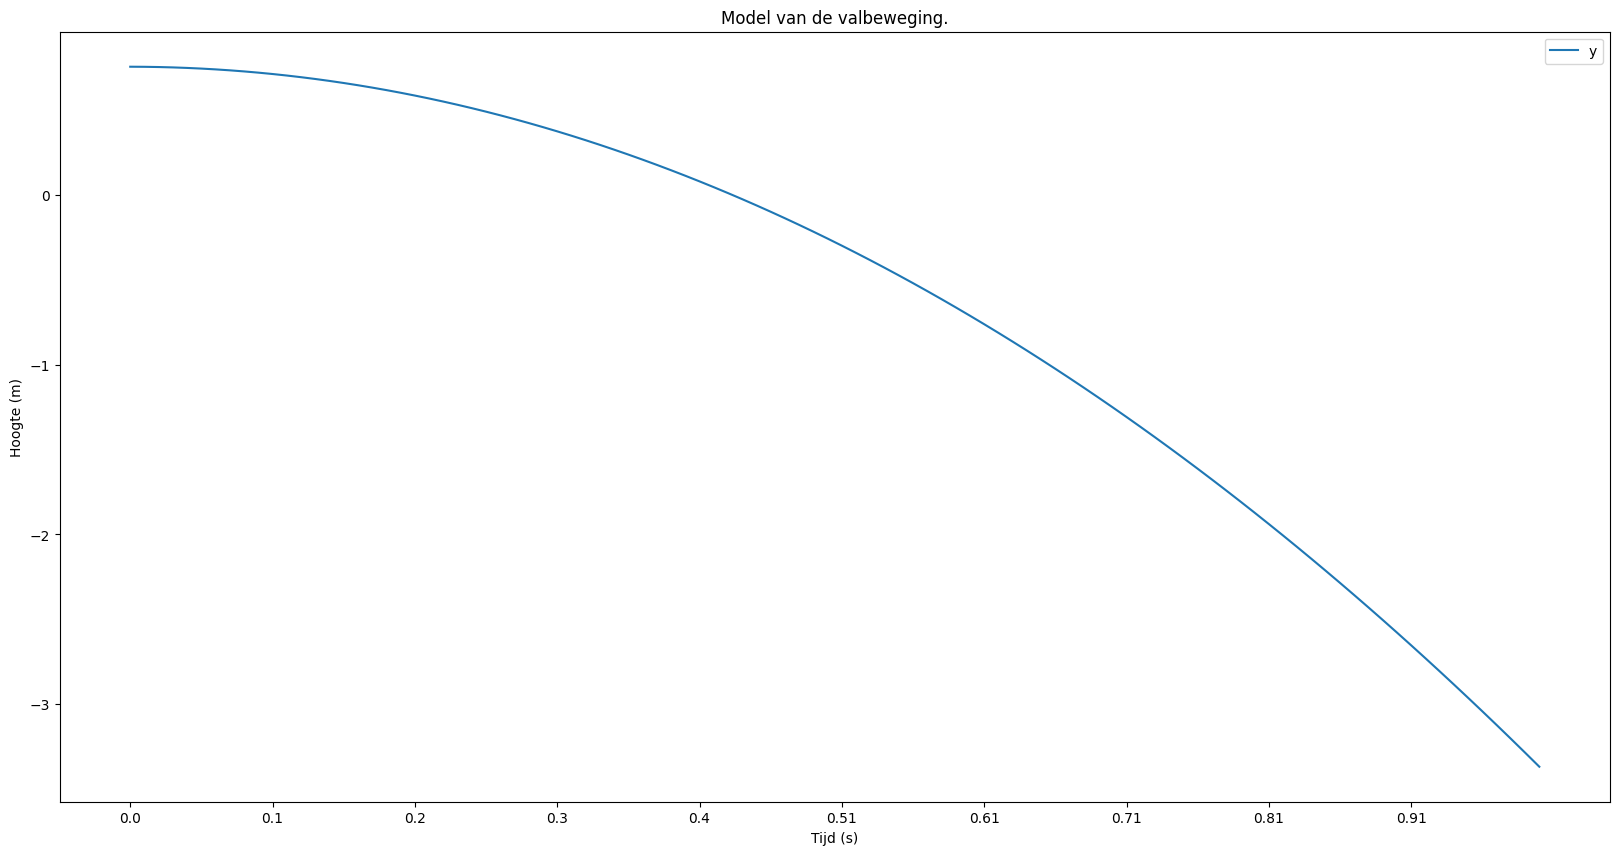

In [20]:
# Plot de vergelijking met de nieuwe coëfficiënten
x = np.linspace(0, 1, 100)
y = coef[0] * x**2 + coef[1] * x + coef[2]
plot_gegevens(y.reshape(-1, 1), x, "Model van de valbeweging.")



In [125]:
# Beginhoogte volgens het wiskundig model
beginhoogte = coef[0] * 0**2 + coef[1] * 0 + coef[2]
print(f'Beginhoogte model: {beginhoogte} cm')
print(f'Beginhoogte data: {afstanden[0]} cm')

Beginhoogte model: 0.7557933654324637 cm
Beginhoogte data: [0.75859649] cm


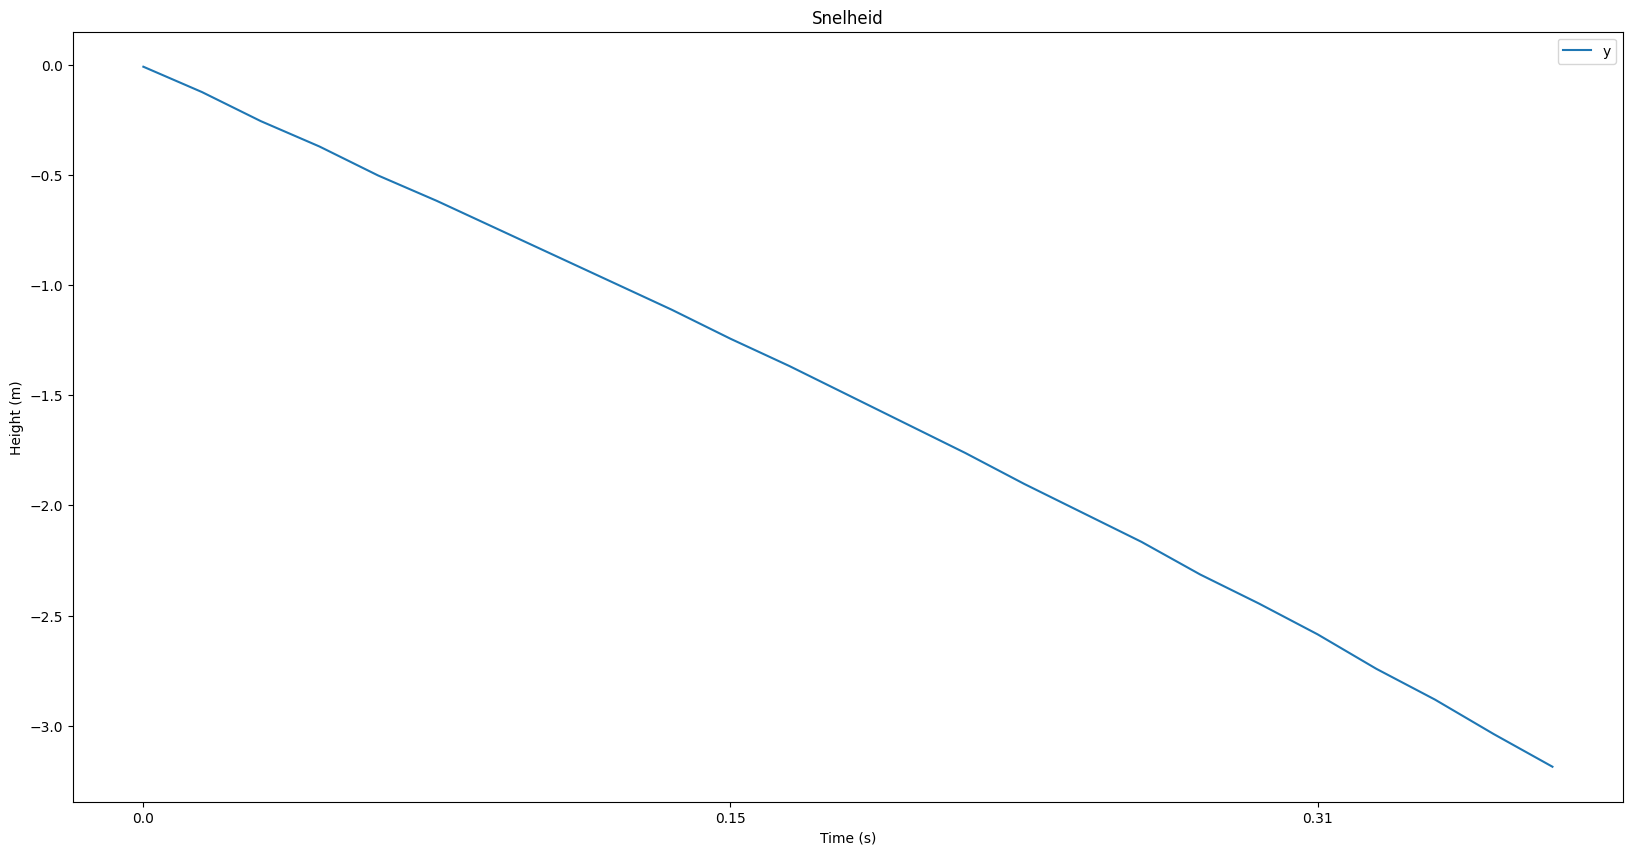

In [126]:
# Door de afgeleide van deze functie te bepalen, kunnen we het verloop van de snelheid van het object bekijken
# De afgeleide van de functie y = a*x^2 + b*x + c is y' = 2*a*x + b

snelheden = 2 * coef[0] * tijden + coef[1]
plot_axis_data(snelheden.reshape(-1, 1), tijden, 'Snelheid')

We merken dat de snelheid steeds negatiever wordt. Dit wil dus zeggen dat hoe langer het object valt, hoe sneller het zal gaan. Tot het de grond raakt natuurlijk.

[-8.22859727 -8.22859727 -8.22859727 -8.22859727 -8.22859727 -8.22859727
 -8.22859727 -8.22859727 -8.22859727 -8.22859727 -8.22859727 -8.22859727
 -8.22859727 -8.22859727 -8.22859727 -8.22859727 -8.22859727 -8.22859727
 -8.22859727 -8.22859727 -8.22859727 -8.22859727 -8.22859727 -8.22859727
 -8.22859727]


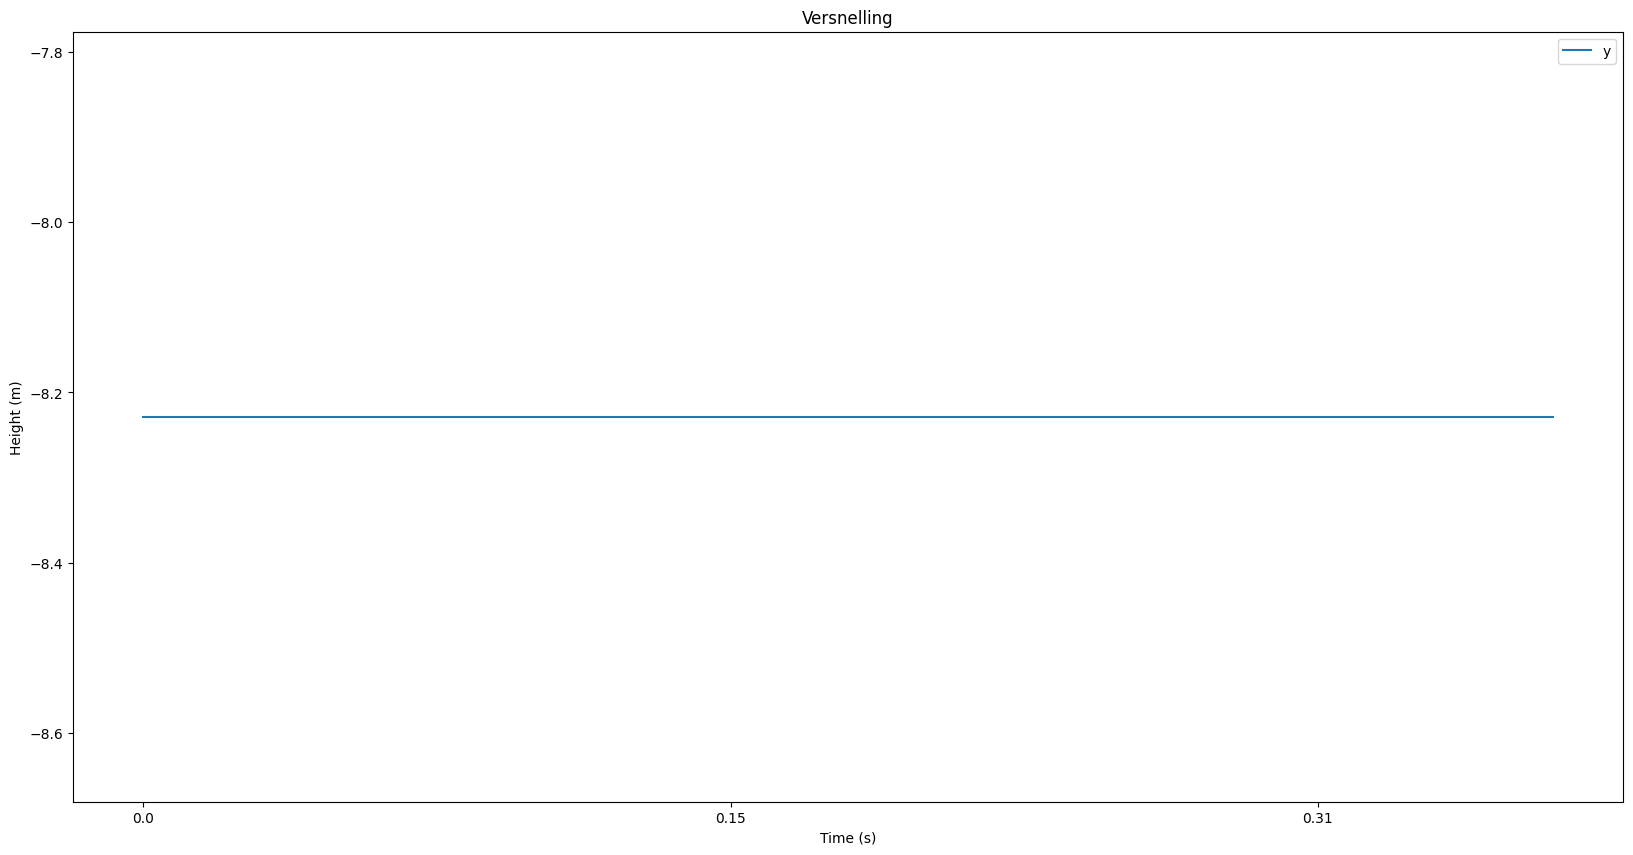

In [127]:
# De versnelling van het object kunnen we ook analyseren door de afgeleide van de snelheid te nemen
# De afgeleide van de snelheid is constant en gelijk aan 2*a
versnellingen = 2 * coef[0] * np.ones_like(tijden)	
print(versnellingen)

plot_axis_data(versnellingen.reshape(-1, 1), tijden, 'Versnelling')

We zien dat de versnelling van het object 8,22 m/s² is. Dat is niet exact de valversnelling die we in boeken kunnen lezen (9,81 m/s²) maar ligt er ook niet ver van. De versnelling is hier negatief omdat we in ons referentiekader ervoor gekozen hebben om de positieve z-as naar boven te doen wijzen.

# Opdracht

We hebben nu een wiskundig model van onze valbeweging. Dit model kunnen we nu gebruiken om voorspellingen te doen. 

Gebruik het wiskundig model om te voorspellen hoe lang het voorwerp zal vallen als we het vanop een hoogte van 2m laten vallen.